# Selective Capacitated Fair Pickup and Delivery Problem - Part II


## 0.) Introduction, setup & code layout

### Code Setup

we begin by implementing all the necessary pyackages, as well as the functions and classes defined in other files

In [1]:
#from misc.script import solution
from src.instance import Instance
from src.misc import *
from src.route import Route
from src.solution import Solution
from src.alns import *
from src.plots import *
import os
import numpy as np
import copy
import pandas as pd

We have defined three classes _Instance_, _Route_, and _Solution_ to hold metainformation about the instance we are dealing with as well as to streamline the way our algorithms deal with underlying data strucutres.
* **Instance:**
The Instance class represents a problem instance and stores all static input data, including the number of requests and vehicles, vehicle capacity, minimum service level, fairness parameter, depot location, and pickup–delivery coordinates with associated demands. It provides functionality to parse and load instance files and serves as a read-only data container throughout the algorithm.

* **Route:**
The Route class models the route of a single vehicle as an ordered sequence of pickup and delivery nodes. It maintains derived route information such as load profiles, remaining capacity slack, and total route length, and provides methods for feasibility checks, incremental cost evaluation, and local modifications (e.g., insertion and removal of requests), which are heavily used by destroy and repair operators. To make this more efficient, these methods are using delta-evaluation.

* **Solution:**
The Solution class represents a complete solution consisting of one route per vehicle, together with global information such as total distance, fairness value, overall objective cost, and the set of unserved requests. It supports solution-level operations including feasibility checks, cost recomputation, fast lookup of request-to-route assignments, visualization, and exporting solutions in the required output format.

The following code snippet demonstrates how the Instance class is used, how we can apply an algorithm to an instance class, and how we can initialize the routes and solution class.

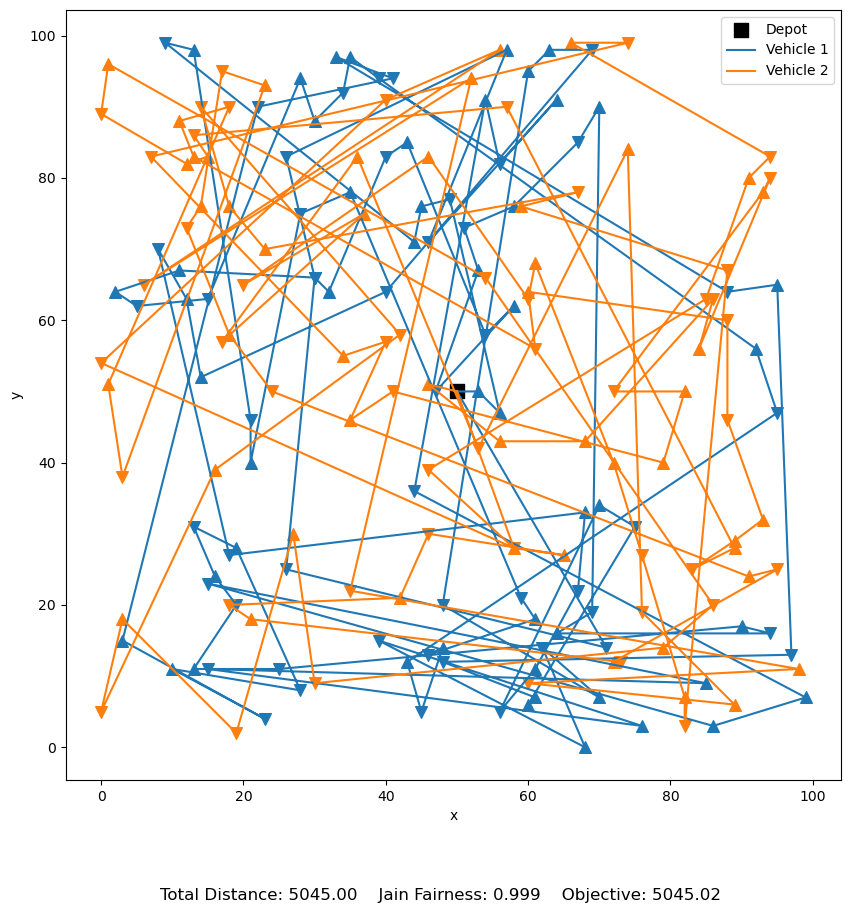

In [2]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
s0 = Solution(instance) #initializig initial solution
routes_array = nearest_neighbor_heuristic(instance) # since the NN-constr.heur. is imported from the 1st assignment, it does not natively include the new data structures yet and returns arrays
s0.load_from_arrays(routes_array) # thus we initialize the routes & solutions with arrays
s0.plot() # the solution class offers the possibility to plot the results in an intuitive way

## 1.) Implementing two algorithms

## Adaptive Large Neighborhood Search
We implement an Adaptive Large Neighborhood Search (ALNS) framework that iteratively improves an initial feasible solution by alternating between destroy and repair phases. In each iteration, a subset of requests is removed using one of several destroy operators (random, worst, Shaw-related, or heavy-demand removal), after which feasibility is restored using either a greedy or a regret-3 insertion heuristic. Operator selection is governed by adaptive weights that are periodically updated based on their empirical success rates, enabling the algorithm to balance diversification and intensification dynamically.

Candidate solutions are accepted according to a simulated annealing criterion, allowing controlled acceptance of worsening moves to escape local optima, while improvements are always accepted and tracked as the current best solution. Throughout the search, detailed iteration-level statistics—including objective value, operator usage, acceptance decisions, runtime, and temperature—are logged to facilitate post hoc performance analysis and operator diagnostics.

We have created a class to store the parameters for the ALNS in a convenient way. This is helpful for later, because we can test different configurations for this algoritm more easily. Down below is an example how to use this algorithm, with not optimized parameter settings.

In [34]:
params = ALNSParams(
    T0=10.0,          # Initial temperature
    cooling=0.975,      # Cooling rate
    destroy_fraction=7,  # how many of the nodes get destroyed in each iteration
    rho=0.25,           # Reaction factor (also sometimes called gamma)
    reward_best=7.0,   # Reward for finding a new best solution
    reward_accept=0.0, # Reward for accepting a solution
    reward_reject=-2.0, # Reward for rejecting a solution
    max_gap = 30,   # maximum distance between pick up and drop off
    regret_k = 2 #this is actually hardcoded, modifying this doesn't change anything
)

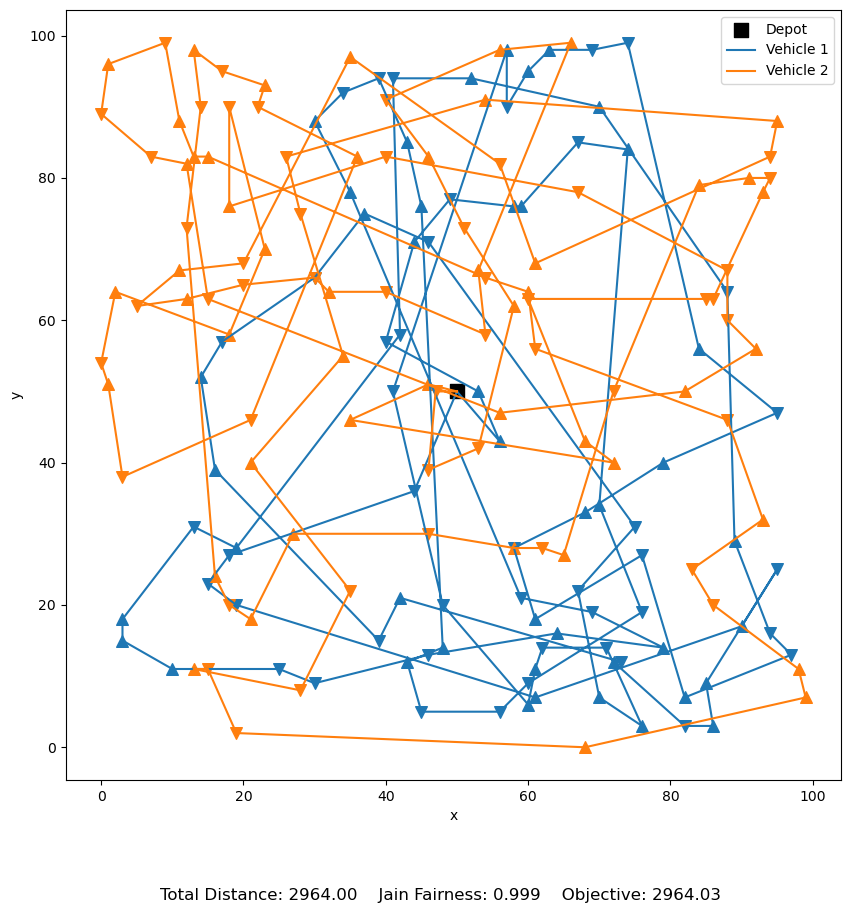

In [35]:
new_s = alns(instance, s0,params ,iters = 2000)
new_s.plot()

### Performance of non optimized ALNS
We tested the our ALNS with more or less random parameters for 5000 iterations. These are the results:

In [36]:
# Load the CSV file into a DataFrame
df = pd.read_csv("alns_log.csv")
df

,iteration,objective,destroy_op,repair_op,accepted,new_best,time_sec,temperature
0,0,4966.015477,2,1,True,True,0.017295,10.00000
1,1,4663.005400,0,0,True,True,0.159109,9.75000
2,2,4097.036286,1,0,True,True,0.124471,9.75000
3,3,4033.002377,3,0,True,True,0.092871,9.75000
4,4,3882.044578,0,0,True,True,0.086727,9.75000
...,...,...,...,...,...,...,...,...
1995,1995,2995.012243,0,0,False,False,0.098661,0.06323
1996,1996,3021.024965,0,0,False,False,0.086121,0.06323
1997,1997,2983.042083,0,0,False,False,0.096544,0.06323
1998,1998,2972.034278,2,0,False,False,0.096431,0.06323


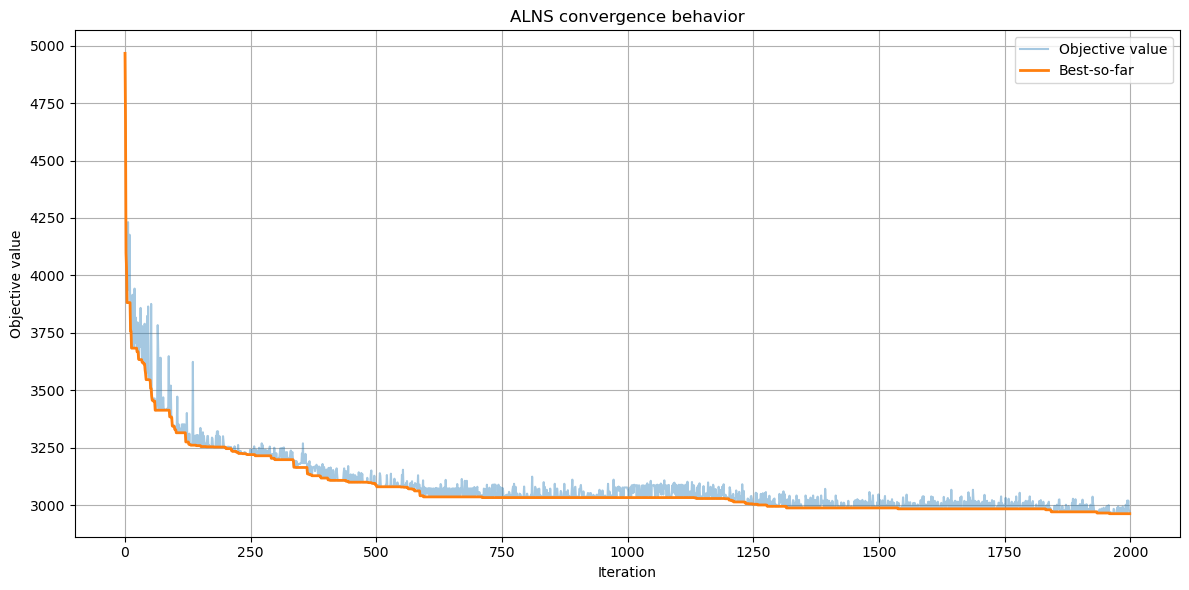

In [37]:
plot_objective_vs_iteration(df)

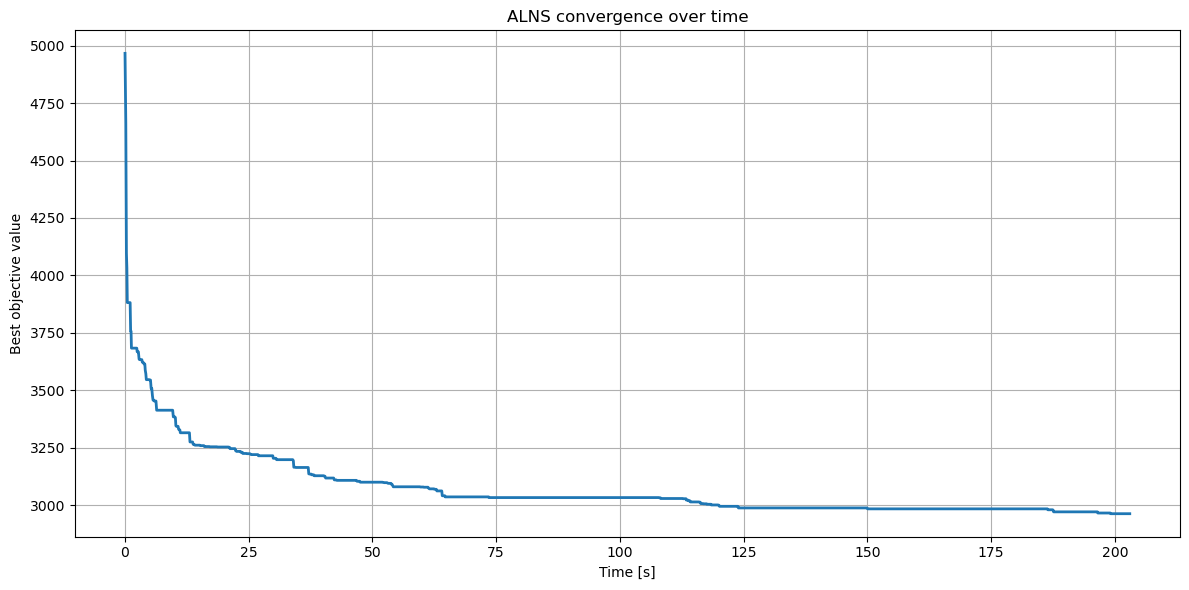

In [38]:
plot_objective_vs_time(df)

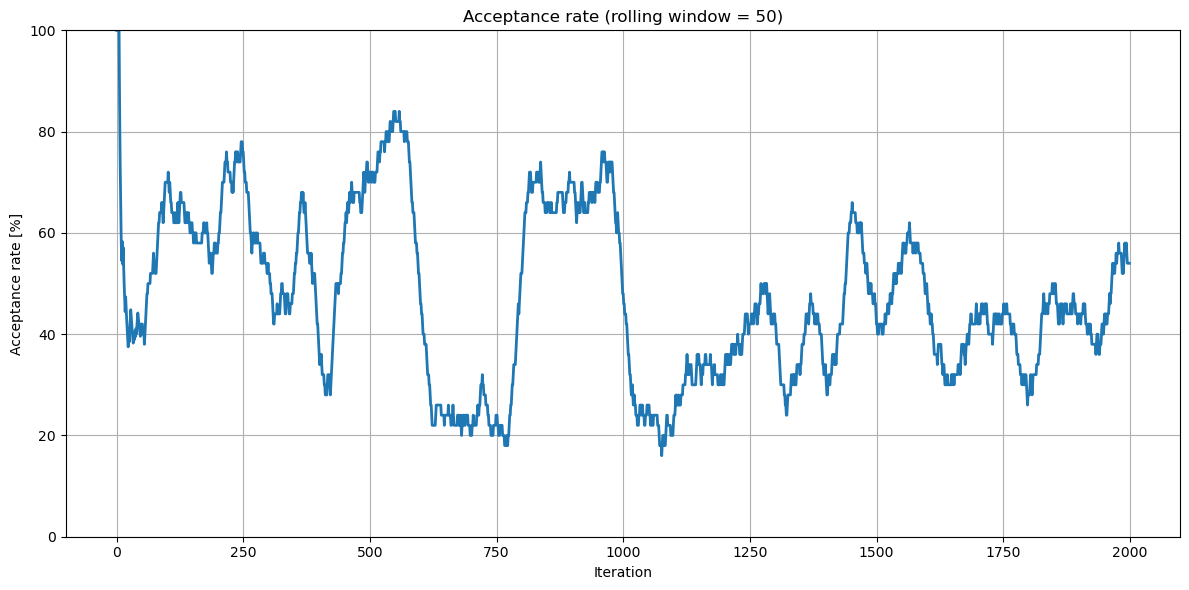

In [39]:
plot_acceptance_rate(df, 50)

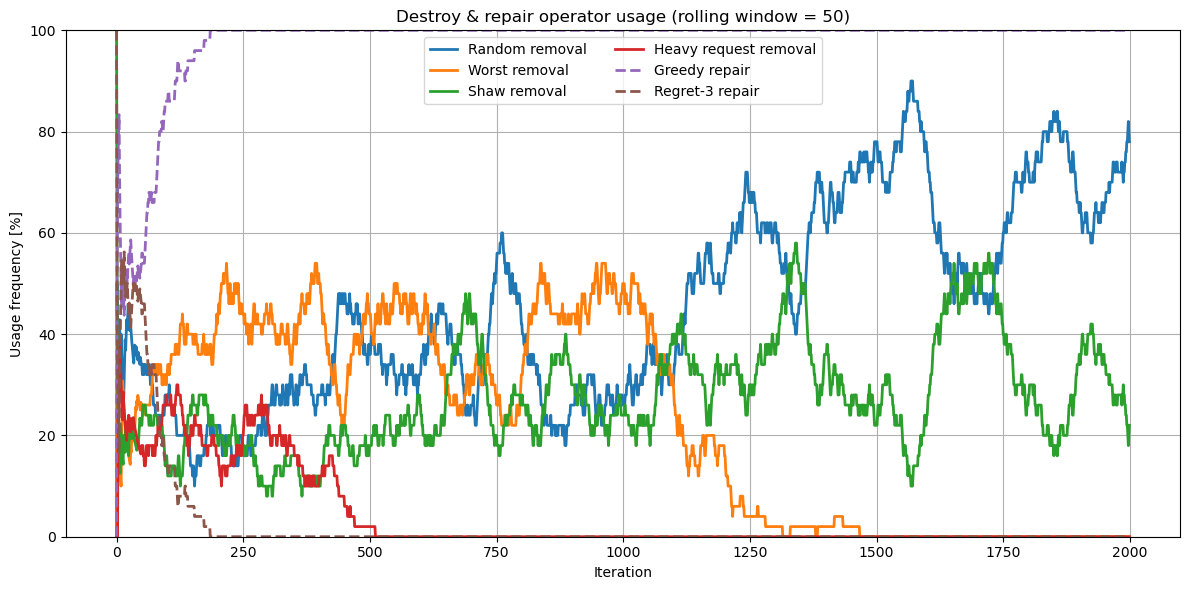

In [40]:
plot_operator_usage_combined(df, 50)

## 2nd algorithm ToDo pls @david
Here we implement another alogrihmt, [ACO/LNS/GA]

## 2.) Experimenting with different fairness mesaures

### Min-Max Fairness

### Gini coefficient

## 3.) Tuning our algorithms

### Tuning ALNS parameters
We use the irace package as introduced in the lecture slides to find the optimal parameter configuration. We run tests on all instances for n = 100, and set a maximum time limit of 10h. We test the following parameter values:

| Parameter        | Values                                                                                     |
|------------------|-------------------------------------------------------------------------------------------|
| T0              | 10, 15, 20, 25, 30, 40, 50                                                                |
| cooling         | 0.95, 0.975, 0.99                                                                          |
| destroy_fraction| 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40                                                    |
| rho             | 0.25, 0.5, 0.65, 0.75, 0.9                                                                |
| reward_best     | 2, 5, 6, 7, 0                                                                              |
| reward_accept   | 0, 1, 2                                                                                   |
| reward_reject   | -2, -1, 0                                                                                  |
| max_gap         | 3, 5, 7, 10, 15, 20, 25, 30, 35, 40                                                       |
| iters           | 100, 200, 300, 400, 500, 1000, 1500, 2000                                                |

Some parameters, like destroy_fraction or iters, strongly influence the runtime of the algorithm. Since we only have limited time, we want to force the algorithm to find the best possible solution in the shortest possible time. We thus set a maximum time per ALNS run of 2.5 minutes - if the algorithm exceed this time, it gets stopped and received a large penalty objective score of 5000. This design forces irace to trade off solution quality against computational efficiency, as faster configurations can perform more iterations within the time limit, while slower configurations are penalized. Furthermore, training on all 30 test instances forces irace to create robust configurations. With an average time of 169 seconds per run, the tuning procedure took about 7h in total.

These were the best configurations irace came up with:

| T0  | cooling | destroy_fraction | rho  | reward_best | reward_accept | reward_reject | max_gap | iters |
|-----|---------|-------------------|------|-------------|---------------|----------------|---------|-------|
| 10  | 0.975   | 7                 | 0.25 | 7           | 0             | -2             | 7       | 2000  |
| 25  | 0.975   | 7                 | 0.25 | 7           | 0             | -2             | 7       | 1500  |
| 10  | 0.975   | 10                | 0.25 | 7           | 0             | -2             | 7       | 1500  |
| 40  | 0.95    | 7                 | 0.5  | 7           | 1             | -2             | 7       | 500   |
| 10  | 0.95    | 10                | 0.25 | 7           | 2             | -2             | 7       | 1500  |

We observe a consistent trend across the elite configurations. Effective parameter settings tend to use a relatively low initial temperature combined with a medium to fast cooling rate, a medium destroy fraction, and a low value of ρ. Furthermore, a high reward for the best action and a fixed medium insertion window length (max_gap=7) appear to be particularly important, as they are shared by all top configurations. Finally, configurations with a high number of iterations consistently perform well, indicating that—within the imposed time limit—solution quality benefits more from additional iterations than from more aggressive parameter settings.

## 4.) Testing our algortihms

## 5.) Comparing algorithms